# Fast Fourier Transform (FFT)
The following gives background information that is helpful to understand how the Fast Fourier Transform (FFT) and the corresponding normalizations are defined in pyfar and how these are related to the concepts of energy and power signals.


## FFT definition
The discrete Fourier transform (DFT) of an arbitrary, but band-limited signal $x(n)$ is defined as
$$ X(k) = \sum_{n=0}^{N-1} x(n) e^{-i 2 \pi k \frac{n}{N}}$$
using a negative sign convention in the transform kernel $e^{-i 2 \pi k \frac{n}{N}}$, and normalized angular frequency $\omega_k = 2 \pi k / N$. Analogously, the inverse discrete Fourier transform (IDFT) is implemented as

$$ x(n) = \frac{1}{N} \sum_{k=0}^{N-1} X(k) e^{i2\pi k \frac{n}{N}}$$

The *Fast Fourier Transform* denotes the efficient implementation of DFT and IDFT.

Note that real-valued time signals result in Fourier spectra with complex conjugate symmetry for negative and positive frequencies $X(k) = X(-k)^*$. In this case, the left-hand side of the spectrum can be discarded, and only the right-hand side needs to be saved.

## FFT normalizations
Pyfar implements five normalizations  after [Ahrens at al. (2020)](http://www.aes.org/e-lib/browse.cfm?elib=20838) that can be applied to spectra after the DFT. The normalizations are implicitly used by the [pyfar.Signal class](https://pyfar.readthedocs.io/en/stable/classes/pyfar.audio.html#pyfar.classes.audio.Signal), and are available from [pyfar.dsp.fft.normalization](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.fft.html#pyfar.dsp.fft.normalization). For a Signal object `signal`, `signal.freq` contains the normalized spectrum according to `signal.fft_norm` and `signal.freq_raw` contains the raw spectrum without any normalization. **The time data (**`signal.time`**) does not change regardless of the normalization.**

| Normalization| Equation                                                                                                 |
|-------------|----------------------------------------------------------------------------------------------------------|
| `'none'`    | --                                                                                                       |
| `'unitary'` | $X_{\text{SS}}(k) = \left\{ \begin{array}{ll} X(k) & \forall k=0, k=\frac{N}{2} \\ 2 X(k) & \forall 0<k< \frac{N}{2} \end{array} \right.$|
| `'amplitude'` | $\overline{X}_{\text{SS}}(k) = \frac{1}{N} X_{\text{SS}}(k)$                                          |
| `'rms'`       | $\overline{X}_{RMS}(k) = \left\{ \begin{array}{ll} \frac{1}{\sqrt{2}} \overline{X}_{\text{SS}}(k) & \forall 0<k< \frac{N}{2} \\ \quad \overline{X}_{\text{SS}}(k) & \forall k=0, k=\frac{N}{2} \end{array} \right.$|
| `'power'`     | $\overline{\overline{X}}_{\text{SS}}(k) = \lvert \overline{X}_{\text{RMS}}(k) \lvert ^2$           |
| `'psd'`       | $\overline{\overline{\underline{X}}}_{\text{SS}}(k) = \frac{N}{f_s} \overline{\overline{X}}_{\text{SS}}(k) = \frac{N}{f_s} \lvert \overline{X}_{\text{RMS}}(k) \lvert ^2$|

Note that the above formulation holds for real-valued signals with single-sided spectra $X_{\text{SS}}(k)$. Hence, there are small differences in the definitions compared to the formulas written in [Ahrens et al. (2020)](http://www.aes.org/e-lib/browse.cfm?elib=20838).

## Example signals
Four signals with a length of 100 samples and a sampling rate of 10 kHz are used for illustrating the normalizations.

In [2]:
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt


# set number of samples and sampling rate
n_samples = 1e3
sampling_rate = 10e3

An **impulse** ($x(0)=1$ and zero otherwise) with a constant spectrum.
<!-- This is an energy signal, so the appropriate normalization is `'none'` (the default). -->

In [3]:
impulse = pf.signals.impulse(n_samples, sampling_rate=sampling_rate)

A **fractional octave FIR filter** presenting a system with finite energy (e.g., a loudspeaker transfer function, a room impulse response, an HRTF ...).
<!-- It is an energy signal, so the appropriate normalization is `'none'`. -->

In [4]:
fir = pf.dsp.filter.fractional_octave_bands(
    impulse, num_fractions=1, freq_range=(500, 700))

A **sine** signal with an amplitude of $1\,\text{Pa}$. It represents a discrete tone of which a snippet was recorded.
<!-- Accordingly, it possess a finite power but infinite energy and is a power signal with appropriate normalizations `'amplitude'`, `'rms'`, or `'power'`. -->

In [5]:
sine = pf.signals.sine(1e3, n_samples, sampling_rate=sampling_rate)

A **white noise** signal with an RMS value of $1/\sqrt{2}\,\text{Pa}$. It represents a broadband stochastic signal of which a snippet was recorded of.
<!-- Accordingly, it is a power signal with the appropriate normalization `'psd'`. -->

In [6]:
noise = pf.signals.noise(n_samples, rms=1/np.sqrt(2), sampling_rate=sampling_rate)

## `'none'`
The `'none'` normalization (the default) uses the FFT spectrum as it is. This norm is to be used for energy signals such as impulse responses, as illustrated below by the impulse and FIR filter. With this normalization, the spectrum is independent of the signal length. Yet, the spectrum depends on the number of samples for power signals, such as the sine and noise ("longer signal = more energy"). For example, the magnitude of the sine equals of number of samples/2 (1000/2, 60-6 dB). Other normalizations are appropriate for power signals. 

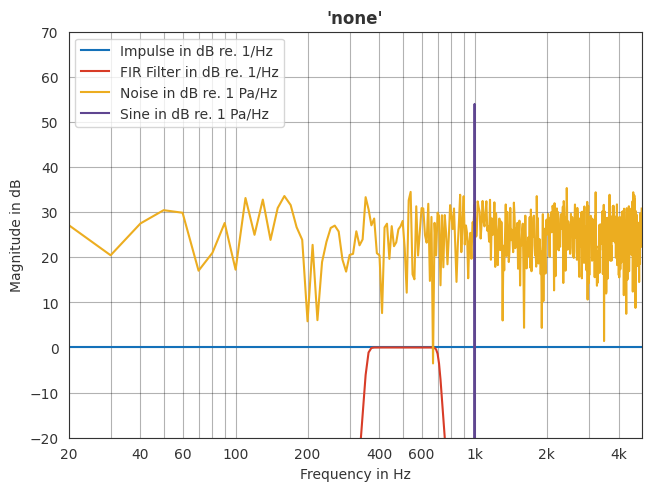

In [11]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'none'

ax = pf.plot.freq(impulse, label="Impulse in dB re. 1/Hz")
pf.plot.freq(fir, label="FIR Filter in dB re. 1/Hz")
pf.plot.freq(noise, label="Noise in dB re. 1 Pa/Hz")
pf.plot.freq(sine, label="Sine in dB re. 1 Pa/Hz")

ax.set_title("'none'")
ax.set_ylim(-20, 70)
ax.legend(loc='upper left')

## `'unitary'`
The FFT-calculated spectrum is multiplied by a factor of 2 in order to represent power related measures correctly.  This results in +6 dB in magnitude in the plot below compared to the `'none'`' normalization. **All following normalizations make use of this (implicitly assuming real-valued time signals, i.e., signals with single-sided spectrum).**

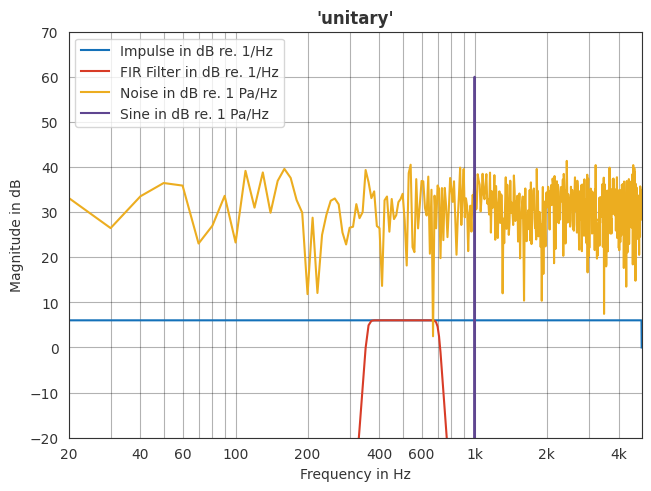

In [12]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'unitary'

ax = pf.plot.freq(impulse, label="Impulse in dB re. 1/Hz")
pf.plot.freq(fir, label="FIR Filter in dB re. 1/Hz")
pf.plot.freq(noise, label="Noise in dB re. 1 Pa/Hz")
pf.plot.freq(sine, label="Sine in dB re. 1 Pa/Hz")

ax.set_title("'unitary'")
ax.set_ylim(-20, 70)
ax.legend(loc='upper left')

## `'amplitude'`
The spectrum is normalized to show the amplitude of the pure tone components contained in a signal by considering the number of samples. Accordingly, the sine signal with an amplitude of 1 has an absolute value of 1 Pa (0 dB) at the frequency of the sine, with the implied unit "Pa" being illustrated correctly.

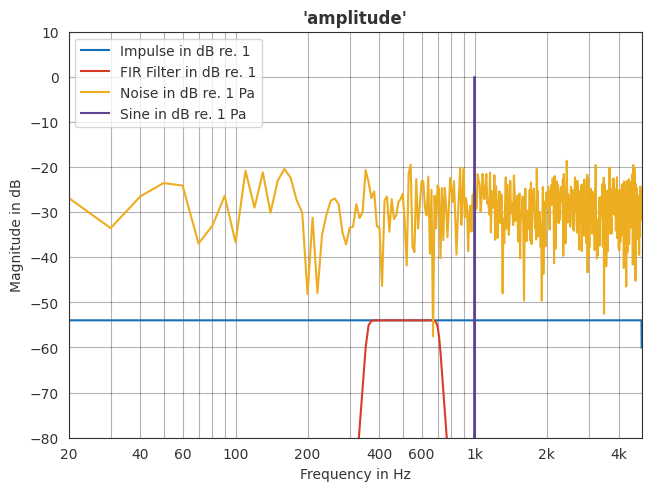

In [16]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'amplitude'

ax = pf.plot.freq(impulse, label="Impulse in dB re. 1")
pf.plot.freq(fir, label="FIR Filter in dB re. 1")
pf.plot.freq(noise, label="Noise in dB re. 1 Pa")
pf.plot.freq(sine, label="Sine in dB re. 1 Pa")

ax.set_title("'amplitude'")
ax.set_ylim(-80, 10)
ax.legend(loc='upper left')

## `'rms'`
The spectrum is normalized to show the RMS value of the pure tone components contained in a signal. This results in a magnitude of -3 dB re. 1 Pa of the sine.

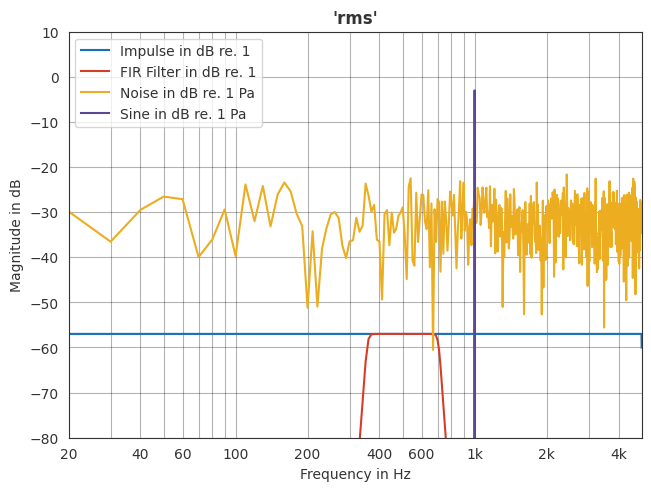

In [17]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'rms'

ax = pf.plot.freq(impulse, label="Impulse in dB re. 1")
pf.plot.freq(fir, label="FIR Filter in dB re. 1")
pf.plot.freq(noise, label="Noise in dB re. 1 Pa")
pf.plot.freq(sine, label="Sine in dB re. 1 Pa")

ax.set_title("'rms'")
ax.set_ylim(-80, 10)
ax.legend(loc='upper left')

## `'power'`
In a dB representation, `'power'` normalization equals the `'rms'` normalization, when correctly accounting for the prefix 10 in the dB calculation. Though meaningful for pure tones, these normalizations result in a dependence of the magnitude on the sampling rate for stochastic broadband signals such as the noise signal, as these are defined by a constant power density (see `'psd'`).

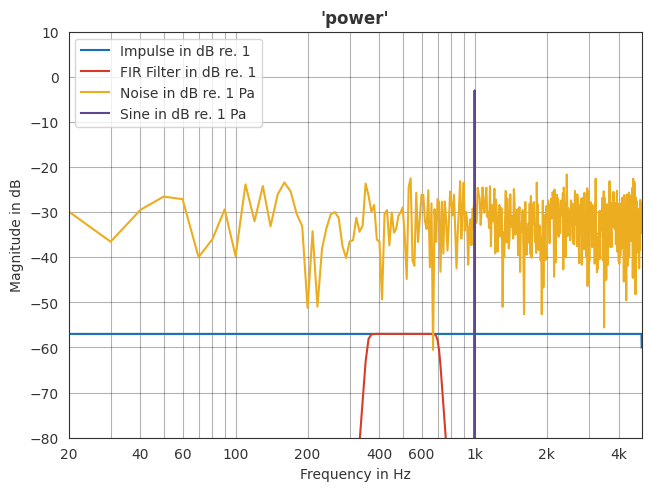

In [20]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'power'

ax = pf.plot.freq(impulse, log_prefix=10, label="Impulse in dB re. 1")
pf.plot.freq(fir, log_prefix=10, label="FIR Filter in dB re. 1")
pf.plot.freq(noise, log_prefix=10, label="Noise in dB re. 1 Pa")
pf.plot.freq(sine, log_prefix=10, label="Sine in dB re. 1 Pa")

ax.set_title("'power'")
ax.set_ylim(-80, 10)
ax.legend(loc='upper left')

## `'psd'`
Using `'psd'` normalization, signals are represented as *power densities* (e.g. in Pa²/Hz), leading to a meaningful representation for broadband stochastic signals independently of the sampling rate. From the examples, this normalization is only meaningful for the noise signal. With this normalization, the sine's magnitude is reduced by a factor of number of samples / sampling rate (1/10, -10 dB) compared to  `'rms'` and `'power'`. 

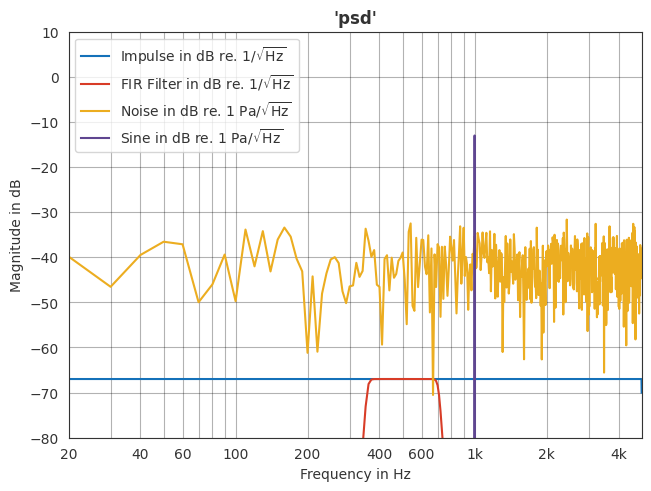

In [26]:
for signal in [impulse, fir, sine, noise]:
    signal.fft_norm = 'psd'

ax = pf.plot.freq(impulse, log_prefix=10, label="Impulse in dB re. 1/$\sqrt{\mathrm{Hz}}$")
pf.plot.freq(fir, log_prefix=10, label="FIR Filter in dB re. 1/$\sqrt{\mathrm{Hz}}$")
pf.plot.freq(noise, log_prefix=10, label="Noise in dB re. 1 Pa/$\sqrt{\mathrm{Hz}}$")
pf.plot.freq(sine, log_prefix=10, label="Sine in dB re. 1 Pa/$\sqrt{\mathrm{Hz}}$")

ax.set_title("'psd'")
ax.set_ylim(-80, 10)
ax.legend(loc='upper left')

## Summary
The table summarizes which normalization to use for which type of signal.

| Signal type            | Variation                              | Normalization          |
|------------------------|----------------------------------------|------------------------|
| Energy                 | Impulse responses / transfer functions | `'none'`               |
| Power                  | Discrete tones                         | `'amplitude'`, `'rms'`, `'power'` |
| Power                  | Broadband stochastic signals           | `'psd'`              |

For further details, especially on the background of the power normalizations, it is referred to [Ahrens at al. (2020)](http://www.aes.org/e-lib/browse.cfm?elib=20838). See [pyfar.dsp.fft](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.fft.html) for a complete documentation.

## Reference
[J. Ahrens, C. Andersson, P. Höstmad, and W. Kropp, “Tutorial on Scaling of the Discrete Fourier Transform and the Implied Physical Units of the Spectra of Time-Discrete Signals,” AES Convention e-Brief 600, May 2020.](http://www.aes.org/e-lib/browse.cfm?elib=20838)